<a href="https://colab.research.google.com/github/bsoifer/AnalisisPredictivo/blob/main/TP2_Bruno_Soifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico #2: Bruno Soifer (62423)


---
[Competencia de Kaggle](https://www.kaggle.com/competitions/analisis-predictivo-2023q1)

[Prueba de modelos](https://colab.research.google.com/drive/1XY4EKW-XluzGQ29q0NIKMmkT9uMeXwSn?usp=sharing)

## Lectura de la base

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor 
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, make_scorer
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive' , force_remount = True)
with open("/content/drive/My Drive/kaggle.json" , 'r') as f:
  api_token = json.load(f)

  with open('/root/.kaggle/kaggle.json' , 'w') as file:
    json.dump(api_token , file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c analisis-predictivo-2023q1

import zipfile
import os

os.listdir()

for file in os.listdir():
  if file.endswith('.zip'):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Mounted at /content/drive
analisis-predictivo-2023q1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [65]:
data = pd.read_csv('base_train.csv')

In [66]:
test = pd.read_csv('base_val.csv')

## Transformación de columnas (train)

In [10]:
#Columna id
data = data.drop('id', axis = 1)

In [11]:
#Columna source
#Cambio la variable 'source' por un 0 o un 1
le = LabelEncoder()
data["source_encoded"] = le.fit_transform(data["source"])
data['source'] = data['source_encoded']
data = data.drop('source_encoded', axis = 1)

In [12]:
#Columna name
# Calculo el puntaje de sentimiento para cada fila en función de la columna "name"
data['name_num'] = data['name'].apply(lambda name: TextBlob(name).sentiment.polarity)

#Modifico los valores de la columna "name" por su correspondiente valor numérico.
data['name'] = data['name_num']
data = data.drop('name_num', axis = 1)

In [13]:
#Columna description

#Convierto la columna a string
data['description'] = data['description'].astype(str)

# Calculo el puntaje de sentimiento para cada fila en función de la columna "description"
data['description_num'] = data['description'].apply(lambda name: TextBlob(name).sentiment.polarity)

#Modifico los valores de la columna "description" por su correspondiente valor numérico.
data['description'] = data['description_num']
data = data.drop('description_num', axis = 1)

In [14]:
#Columna neighborhood_overview

#Convierto la columna a string
data['neighborhood_overview'] = data['neighborhood_overview'].astype(str)

# Calculo el puntaje de sentimiento para cada fila en función de la columna "description"
data['neighborhood_overview_num'] = data['neighborhood_overview'].apply(lambda name: TextBlob(name).sentiment.polarity)

#Modifico los valores de la columna "description" por su correspondiente valor numérico.
data['neighborhood_overview'] = data['neighborhood_overview_num']
data = data.drop('neighborhood_overview_num', axis = 1)

In [15]:
#Columna host_id
data = data.drop('host_id', axis = 1)

In [16]:
#Columna host_name
data = data.drop('host_name', axis = 1)

In [17]:
#Columna host_since

#Convierto la columna a formato datetime
data['host_since'] = pd.to_datetime(data['host_since'])

#Convierto de fechas a números, tomando como base la fecha más antigua: 24/09/2008
data['host_since'] = (data['host_since'] - datetime(2008, 9, 24)).dt.days

In [18]:
#Columna host_location

# Crear un diccionario de ubicaciones
locations = data['host_location'].unique()
mapping = {location: i for i, location in enumerate(locations, 1)}

# Aplicar el mapeo a la columna 'host_location'
data['host_location'] = data['host_location'].replace(mapping)

# Reemplazar los valores nulos por cero
data['host_location'] = data['host_location'].fillna(0)

In [19]:
#Columna host_about

#Convierto la columna a string
data['host_about'] = data['host_about'].astype(str)

# Calculo el puntaje de sentimiento para cada fila en función de la columna "host_about"
data['host_about'] = data['host_about'].apply(lambda name: TextBlob(name).sentiment.polarity)

In [20]:
#Columna host_response_time

# Creo un diccionario de mapeo de valores
mapping_response_time = {'within an hour': 4, 'within a few hours': 3, 'within a day': 2, 'a few days or more': 1}

# Aplico el mapeo a la columna 'host_response_time'
data['host_response_time'] = data['host_response_time'].replace(mapping_response_time)

# Reemplazar los valores nulos por cero
data['host_response_time'] = data['host_response_time'].fillna(0)

In [21]:
#Columna host_response_rate

# Defino una función lambda para convertir el porcentaje a un número decimal
to_decimal = lambda x: float(x.strip('%'))/100 if isinstance(x, str) else 0

# Aplicar la función lambda a la columna 'porcentaje'
data['host_response_rate'] = data['host_response_rate'].apply(to_decimal)

In [22]:
#Columna host_acceptance_rate

# Defino una función lambda para convertir el porcentaje a un número decimal
to_decimal = lambda x: float(x.strip('%'))/100 if isinstance(x, str) else 0

# Aplicar la función lambda a la columna 'porcentaje'
data['host_acceptance_rate'] = data['host_acceptance_rate'].apply(to_decimal)

In [23]:
#Columna host_is_superhost

# Convertir la columna 'host_is_superhost' a numérico, poniendo un 1 si el valor es TRUE y 0 en cualquier otro caso
data['host_is_superhost'] = data['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0 if x == 'f' or pd.isna(x) else None)

In [24]:
#Columna host_neighbourhood

# Crear un diccionario de ubicaciones
locations_2 = data['host_neighbourhood'].unique()
mapping_2 = {location: i for i, location in enumerate(locations_2, 1)}

# Aplicar el mapeo a la columna 'host_neighbourhood'
data['host_neighbourhood'] = data['host_neighbourhood'].replace(mapping_2)

# Reemplazar los valores nulos por cero
data['host_neighbourhood'] = data['host_neighbourhood'].fillna(0)

In [25]:
#Columna host_verifications

#A cada fila le asigno el valor de la cantidad de verificaciones que tiene cada host
def obtener_longitud(verifications):
    return verifications.count(',') + 1

data['host_verifications'] = data['host_verifications'].apply(obtener_longitud)

In [26]:
#Columna host_has_profile_pic

#Convierto la columna 'host_has_profile_pic' a numérico, poniendo un 1 si el valor es 't'' y 0 en cualquier otro caso
data['host_has_profile_pic'] = data['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0 if x == 'f' or pd.isna(x) else None)

In [27]:
#Columna host_identity_verified

#Convierto la columna 'host_identity_verified' a numérico, poniendo un 1 si el valor es 't'' y 0 en cualquier otro caso
data['host_identity_verified'] = data['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0 if x == 'f' or pd.isna(x) else None)

In [28]:
# Columna neighbourhood
data = data.drop('neighbourhood', axis = 1)

In [29]:
# Columna neighbourhood_cleansed

#Crear un diccionario de neighbouhoods
neighbourhoods = data['neighbourhood_cleansed'].unique()
mapping = {location: i for i, location in enumerate(neighbourhoods, 1)}

#Aplicar el mapeo a la columna 'neighbourhood_cleansed'
data['neighbourhood_cleansed'] = data['neighbourhood_cleansed'].replace(mapping)

#Reemplazar los valores nulos por cero
data['neighbourhood_cleansed'] = data['neighbourhood_cleansed'].fillna(0)

In [30]:
#Columna neighbourhood_group_cleansed
data = data.drop('neighbourhood_group_cleansed', axis = 1)

In [31]:
#Columnas coordinate: latitude y longitude

#Creo una nueva columna llamada "coordinates" que contenga las coordenadas en formato de lista
data['coordinates'] = data.apply(lambda row: [row["latitude"], row["longitude"]], axis=1)

# Definimo una función lambda para extraer los valores de latitud y longitud y convertirlos en un valor numérico
to_numeric = lambda x: (float(x[0]), float(x[1]))

# Aplico la función lambda a la columna 'coordinates'
data['coordinates'] = data['coordinates'].apply(to_numeric)

# Definimo el número de clusters a crear
num_clusters = 10

# Creo un objeto KMeans y lo ajusto a las coordenadas
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(list(data['coordinates']))

# Asignamos el cluster correspondiente a cada fila del DataFrame
data['cluster'] = kmeans.labels_

# Asigno los valores la columna 'cluster' a la columna 'coordinates'
data['coordinates'] = data['cluster']
data = data.drop('cluster', axis = 1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
#Columna property_type

#Declaro un LabelEncoder y lo aplico a la columna. Cada valor categórico toma un valor numérico distinto
le = LabelEncoder()
data['property_type'] = le.fit_transform(data['property_type'])

In [33]:
#Columna room_type

#Declaro un LabelEncoder y lo aplico a la columna. Cada valor categórico toma un valor numérico distinto
le = LabelEncoder()
data['room_type'] = le.fit_transform(data['room_type'])

In [34]:
#Columna bathrooms
data = data.drop('bathrooms', axis = 1)

In [35]:
#Columna bathrooms_text
dictionary = {'1.5 baths': 1.5, '1.5 shared baths': 1.5, '1 private bath': 1, '1 shared bath': 1, '1 bath': 1, '2.5 baths': 2.5, '3.5 baths': 3.5, '0 baths': 0, 'Private half-bath': 0.5, '2 baths': 2, '3 baths': 3, '0 shared baths': 0, 'Half-bath': 0.5, 'nan': 0, '5 baths': 5, 'Shared half-bath': 0.5, '2 shared baths': 2, '5.5 baths': 5.5, '4 baths': 4, '4.5 baths': 4.5}
data['bathrooms_text'] = data['bathrooms_text'].map(dictionary)
data['bathrooms_text'].fillna(0, inplace=True)

In [36]:
#Columna bedrooms

#Asigno un cero a los valores nulos
data['bedrooms'].fillna(0, inplace=True)

In [37]:
#Columna beds

#Asigno un cero a los valores nulos
data['beds'].fillna(0, inplace=True)

In [38]:
#Columna amenities

#Defino una función para contar comas y sumar 1 por fila
def contar_comas(row):
    return row.count(',') + 1

# Aplicar la función a la columna 'amenities'
data['amenities'] = data['amenities'].apply(contar_comas)

In [39]:
#Columna price

#Elimino el signo "$" y las comas
data['price'] = data['price'].replace({'\$': '', ',': ''}, regex=True)

#Convierto la columna a tipo numérico
data['price'] = data['price'].astype(float)

In [40]:
#Columna calendar_updated
data = data.drop('calendar_updated', axis = 1)

In [41]:
#Columna has_availability

# Convertir la columna 'has_availability' a numérico, poniendo un 1 si el valor es TRUE y 0 en cualquier otro caso
data['has_availability'] = data['has_availability'].apply(lambda x: 1 if x == 't' else 0 if x == 'f' or pd.isna(x) else None)

In [42]:
#Columna calendar_last_scraped

#Obtengo la representación numérica única para cada fecha
data['calendar_last_scraped'] = pd.factorize(data['calendar_last_scraped'])[0] + 1

In [43]:
#Columna first_review

#Obtengo la representación numérica única para cada fecha
data['first_review'] = pd.factorize(data['first_review'])[0] + 1

In [44]:
#Columna last_review

#Obtengo la representación numérica única para cada fecha
data['last_review'] = pd.factorize(data['last_review'])[0] + 1

In [45]:
#Columna review_scores_accuracy
data['review_scores_accuracy'].fillna(0, inplace=True)

In [46]:
#Columna review_scores_cleanliness
data['review_scores_cleanliness'].fillna(0, inplace=True)

In [47]:
#Columna review_scores_checkin
data['review_scores_checkin'].fillna(0, inplace=True)

In [48]:
#Columna review_scores_communication
data['review_scores_communication'].fillna(0, inplace=True)

In [49]:
#Columna review_scores_location
data['review_scores_location'].fillna(0, inplace=True)

In [50]:
#Columna review_scores_value
data['review_scores_value'].fillna(0, inplace=True)

In [51]:
#Columna license
data['license'] = data['license'].map({'Exempt': 1}).fillna(0)

In [52]:
#Columna instant_bookable

#Convierto la columna 'instant_bookable' a numérico, poniendo un 1 si el valor es TRUE y 0 en cualquier otro caso
data['instant_bookable'] = data['instant_bookable'].apply(lambda x: 1 if x == 't' else 0 if x == 'f' or pd.isna(x) else None)

## Transformación de columnas (en test)

In [67]:
#Columna id
test = test.drop('id', axis = 1)

In [68]:
#Columna source
#Cambio la variable 'source' por un 0 o un 1
le = LabelEncoder()
test["source_encoded"] = le.fit_transform(test["source"])
test['source'] = test['source_encoded']
test = test.drop('source_encoded', axis = 1)

In [69]:
#Columna name
# Calculo el puntaje de sentimiento para cada fila en función de la columna "name"
test['name_num'] = test['name'].apply(lambda name: TextBlob(name).sentiment.polarity)

#Modifico los valores de la columna "name" por su correspondiente valor numérico.
test['name'] = test['name_num']
test = test.drop('name_num', axis = 1)

In [70]:
#Columna description

#Convierto la columna a string
test['description'] = test['description'].astype(str)

# Calculo el puntaje de sentimiento para cada fila en función de la columna "description"
test['description_num'] = test['description'].apply(lambda name: TextBlob(name).sentiment.polarity)

#Modifico los valores de la columna "description" por su correspondiente valor numérico.
test['description'] = test['description_num']
test = test.drop('description_num', axis = 1)

In [71]:
#Columna neighborhood_overview

#Convierto la columna a string
test['neighborhood_overview'] = test['neighborhood_overview'].astype(str)

# Calculo el puntaje de sentimiento para cada fila en función de la columna "description"
test['neighborhood_overview_num'] = test['neighborhood_overview'].apply(lambda name: TextBlob(name).sentiment.polarity)

#Modifico los valores de la columna "description" por su correspondiente valor numérico.
test['neighborhood_overview'] = test['neighborhood_overview_num']
test = test.drop('neighborhood_overview_num', axis = 1)

In [72]:
#Columna host_id
test = test.drop('host_id', axis = 1)

In [73]:
#Columna host_name
test = test.drop('host_name', axis = 1)

In [74]:
#Columna host_since

#Convierto la columna a formato datetime
test['host_since'] = pd.to_datetime(test['host_since'])

#Convierto de fechas a números, tomando como base la fecha más antigua: 24/09/2008
test['host_since'] = (test['host_since'] - datetime(2008, 9, 24)).dt.days

In [75]:
#Columna host_location

# Crear un diccionario de ubicaciones
locations = test['host_location'].unique()
mapping = {location: i for i, location in enumerate(locations, 1)}

# Aplicar el mapeo a la columna 'host_location'
test['host_location'] = test['host_location'].replace(mapping)

# Reemplazar los valores nulos por cero
test['host_location'] = test['host_location'].fillna(0)

In [76]:
#Columna host_about

#Convierto la columna a string
test['host_about'] = test['host_about'].astype(str)

# Calculo el puntaje de sentimiento para cada fila en función de la columna "host_about"
test['host_about'] = test['host_about'].apply(lambda name: TextBlob(name).sentiment.polarity)

In [77]:
#Columna host_response_time

# Creo un diccionario de mapeo de valores
mapping_response_time = {'within an hour': 4, 'within a few hours': 3, 'within a day': 2, 'a few days or more': 1}

# Aplico el mapeo a la columna 'host_response_time'
test['host_response_time'] = test['host_response_time'].replace(mapping_response_time)

# Reemplazar los valores nulos por cero
test['host_response_time'] = test['host_response_time'].fillna(0)

In [78]:
#Columna host_response_rate

# Defino una función lambda para convertir el porcentaje a un número decimal
to_decimal = lambda x: float(x.strip('%'))/100 if isinstance(x, str) else 0

# Aplicar la función lambda a la columna 'porcentaje'
test['host_response_rate'] = test['host_response_rate'].apply(to_decimal)

In [79]:
#Columna host_acceptance_rate

# Defino una función lambda para convertir el porcentaje a un número decimal
to_decimal = lambda x: float(x.strip('%'))/100 if isinstance(x, str) else 0

# Aplicar la función lambda a la columna 'porcentaje'
test['host_acceptance_rate'] = test['host_acceptance_rate'].apply(to_decimal)

In [80]:
#Columna host_is_superhost

# Convertir la columna 'host_is_superhost' a numérico, poniendo un 1 si el valor es TRUE y 0 en cualquier otro caso
test['host_is_superhost'] = test['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0 if x == 'f' or pd.isna(x) else None)

In [81]:
#Columna host_neighbourhood

# Crear un diccionario de ubicaciones
locations_2 = test['host_neighbourhood'].unique()
mapping_2 = {location: i for i, location in enumerate(locations_2, 1)}

# Aplicar el mapeo a la columna 'host_neighbourhood'
test['host_neighbourhood'] = test['host_neighbourhood'].replace(mapping_2)

# Reemplazar los valores nulos por cero
test['host_neighbourhood'] = test['host_neighbourhood'].fillna(0)

In [82]:
#Columna host_verifications

#A cada fila le asigno el valor de la cantidad de verificaciones que tiene cada host
def obtener_longitud(verifications):
    return verifications.count(',') + 1

test['host_verifications'] = test['host_verifications'].apply(obtener_longitud)

In [83]:
#Columna host_has_profile_pic

#Convierto la columna 'host_has_profile_pic' a numérico, poniendo un 1 si el valor es 't'' y 0 en cualquier otro caso
test['host_has_profile_pic'] = test['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0 if x == 'f' or pd.isna(x) else None)

In [84]:
#Columna host_identity_verified

#Convierto la columna 'host_identity_verified' a numérico, poniendo un 1 si el valor es 't'' y 0 en cualquier otro caso
test['host_identity_verified'] = test['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0 if x == 'f' or pd.isna(x) else None)

In [85]:
# Columna neighbourhood
test = test.drop('neighbourhood', axis = 1)

In [86]:
# Columna neighbourhood_cleansed

#Crear un diccionario de neighbouhoods
neighbourhoods = test['neighbourhood_cleansed'].unique()
mapping = {location: i for i, location in enumerate(neighbourhoods, 1)}

#Aplicar el mapeo a la columna 'neighbourhood_cleansed'
test['neighbourhood_cleansed'] = test['neighbourhood_cleansed'].replace(mapping)

#Reemplazar los valores nulos por cero
test['neighbourhood_cleansed'] = test['neighbourhood_cleansed'].fillna(0)

In [87]:
test = test.drop('neighbourhood_group_cleansed', axis = 1)

In [88]:
#Columnas coordinate: latitude y longitude

#Creo una nueva columna llamada "coordinates" que contenga las coordenadas en formato de lista
test['coordinates'] = test.apply(lambda row: [row["latitude"], row["longitude"]], axis=1)

# Definimo una función lambda para extraer los valores de latitud y longitud y convertirlos en un valor numérico
to_numeric = lambda x: (float(x[0]), float(x[1]))

# Aplico la función lambda a la columna 'coordinates'
test['coordinates'] = test['coordinates'].apply(to_numeric)

# Definimo el número de clusters a crear
num_clusters = 10

# Creo un objeto KMeans y lo ajusto a las coordenadas
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(list(test['coordinates']))

# Asignamos el cluster correspondiente a cada fila del TestFrame
test['cluster'] = kmeans.labels_

# Asigno los valores la columna 'cluster' a la columna 'coordinates'
test['coordinates'] = test['cluster']
test = test.drop('cluster', axis = 1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [89]:
#Columna property_type

#Declaro un LabelEncoder y lo aplico a la columna. Cada valor categórico toma un valor numérico distinto
le = LabelEncoder()
test['property_type'] = le.fit_transform(test['property_type'])

In [90]:
#Columna room_type

#Declaro un LabelEncoder y lo aplico a la columna. Cada valor categórico toma un valor numérico distinto
le = LabelEncoder()
test['room_type'] = le.fit_transform(test['room_type'])

In [91]:
#Columna bathrooms
test = test.drop('bathrooms', axis = 1)

In [92]:
#Columna bathrooms_text
dictionary = {'1.5 baths': 1.5, '1.5 shared baths': 1.5, '1 private bath': 1, '1 shared bath': 1, '1 bath': 1, '2.5 baths': 2.5, '3.5 baths': 3.5, '0 baths': 0, 'Private half-bath': 0.5, '2 baths': 2, '3 baths': 3, '0 shared baths': 0, 'Half-bath': 0.5, 'nan': 0, '5 baths': 5, 'Shared half-bath': 0.5, '2 shared baths': 2, '5.5 baths': 5.5, '4 baths': 4, '4.5 baths': 4.5}
test['bathrooms_text'] = test['bathrooms_text'].map(dictionary)
test['bathrooms_text'].fillna(0, inplace=True)

In [93]:
#Columna bedrooms

#Asigno un cero a los valores nulos
test['bedrooms'].fillna(0, inplace=True)

In [94]:
#Columna beds

#Asigno un cero a los valores nulos
test['beds'].fillna(0, inplace=True)

In [95]:
#Columna amenities

#Defino una función para contar comas y sumar 1 por fila
def contar_comas(row):
    return row.count(',') + 1

# Aplicar la función a la columna 'amenities'
test['amenities'] = test['amenities'].apply(contar_comas)

In [96]:
#Columna price

#Elimino el signo "$" y las comas
test['price'] = test['price'].replace({'\$': '', ',': ''}, regex=True)

#Convierto la columna a tipo numérico
test['price'] = test['price'].astype(float)

In [97]:
#Columna calendar_updated
test = test.drop('calendar_updated', axis = 1)

In [98]:
#Columna has_availability

# Convertir la columna 'has_availability' a numérico, poniendo un 1 si el valor es TRUE y 0 en cualquier otro caso
test['has_availability'] = test['has_availability'].apply(lambda x: 1 if x == 't' else 0 if x == 'f' or pd.isna(x) else None)

In [99]:
#Columna calendar_last_scraped

#Obtengo la representación numérica única para cada fecha
test['calendar_last_scraped'] = pd.factorize(test['calendar_last_scraped'])[0] + 1

In [100]:
#Columna first_review

#Obtengo la representación numérica única para cada fecha
test['first_review'] = pd.factorize(test['first_review'])[0] + 1

In [101]:
#Columna last_review

#Obtengo la representación numérica única para cada fecha
test['last_review'] = pd.factorize(test['last_review'])[0] + 1

In [102]:
#Columna review_scores_accuracy
test['review_scores_accuracy'].fillna(0, inplace=True)

In [103]:
#Columna review_scores_cleanliness
test['review_scores_cleanliness'].fillna(0, inplace=True)

In [104]:
#Columna review_scores_checkin
test['review_scores_checkin'].fillna(0, inplace=True)

In [105]:
#Columna review_scores_communication
test['review_scores_communication'].fillna(0, inplace=True)

In [106]:
#Columna review_scores_location
test['review_scores_location'].fillna(0, inplace=True)

In [107]:
#Columna review_scores_value
test['review_scores_value'].fillna(0, inplace=True)

In [108]:
#Columna license
test['license'] = test['license'].map({'Exempt': 1}).fillna(0)

In [109]:
#Columna instant_bookable

#Convierto la columna 'instant_bookable' a numérico, poniendo un 1 si el valor es TRUE y 0 en cualquier otro caso
test['instant_bookable'] = test['instant_bookable'].apply(lambda x: 1 if x == 't' else 0 if x == 'f' or pd.isna(x) else None)

## EDA (train)

### Variables Categóricas

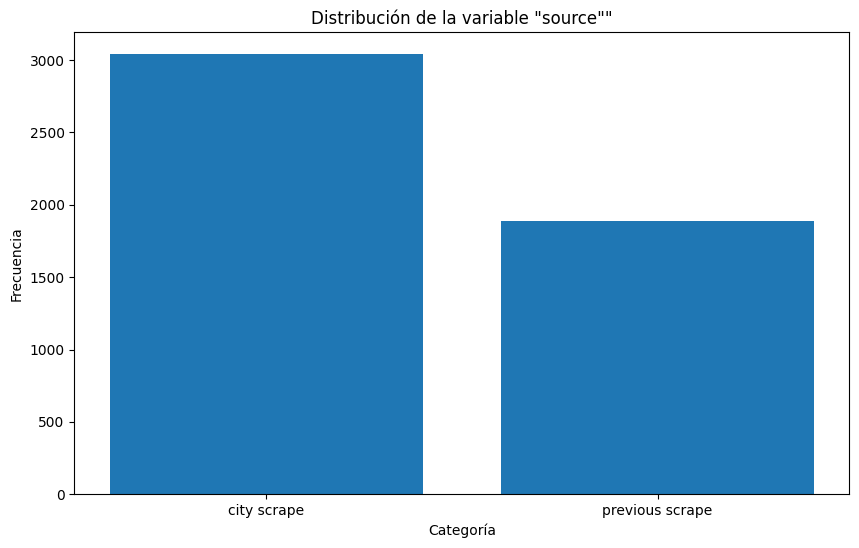

In [5]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(data['source'].value_counts().index, data['source'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "source""')

# Muestra el gráfico
plt.show()

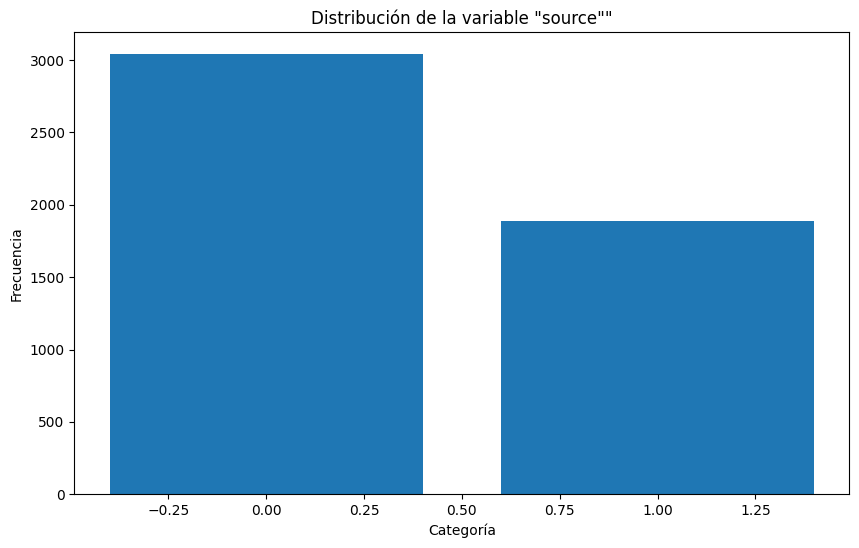

In [ ]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(data['source'].value_counts().index, data['source'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "source""')

# Muestra el gráfico
plt.show()

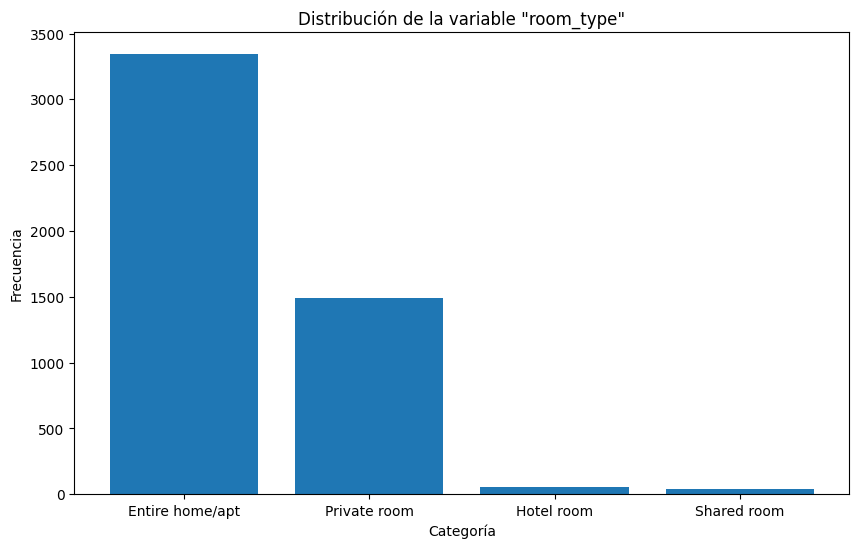

In [6]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(data['room_type'].value_counts().index, data['room_type'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "room_type"')

# Muestra el gráfico
plt.show()

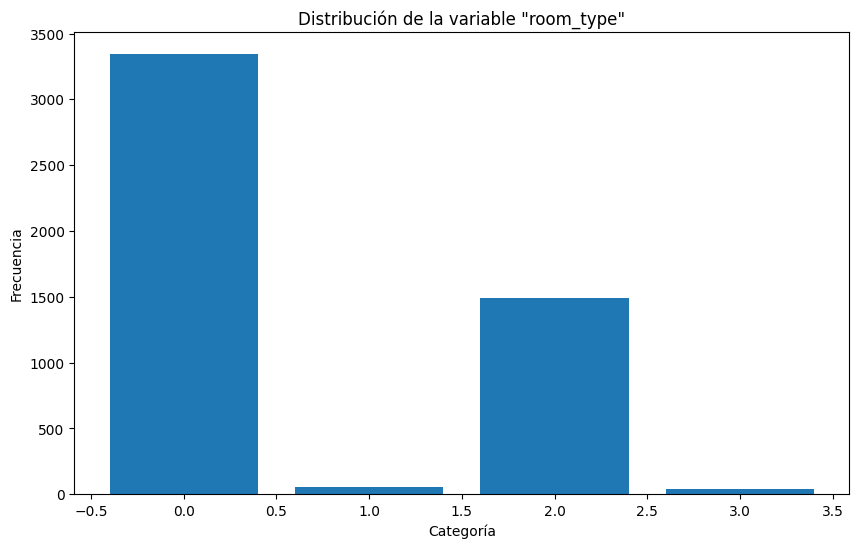

In [ ]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(data['room_type'].value_counts().index, data['room_type'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "room_type"')

# Muestra el gráfico
plt.show()

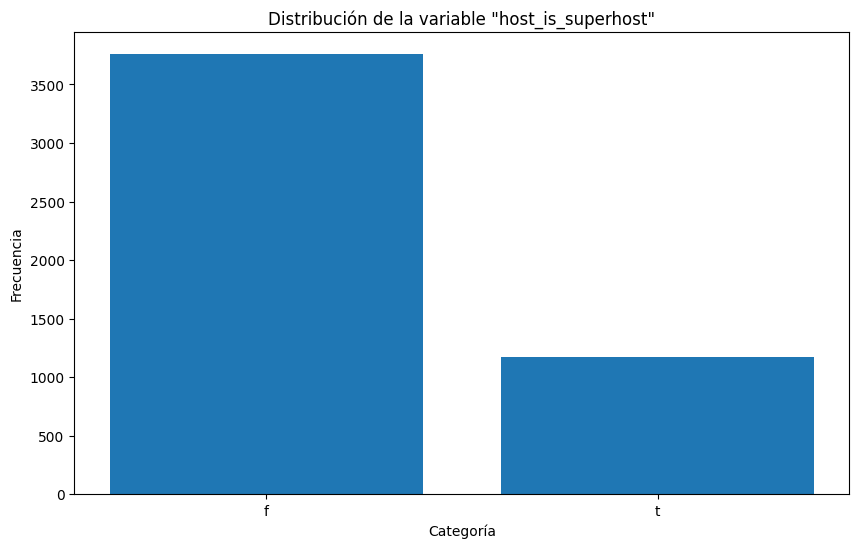

In [7]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(data['host_is_superhost'].value_counts().index, data['host_is_superhost'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "host_is_superhost"')

# Muestra el gráfico
plt.show()

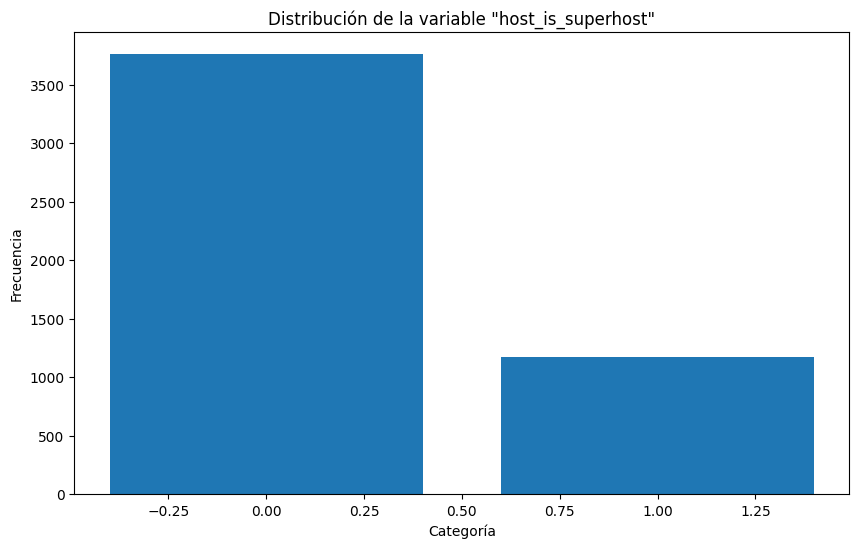

In [ ]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(data['host_is_superhost'].value_counts().index, data['host_is_superhost'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "host_is_superhost"')

# Muestra el gráfico
plt.show()

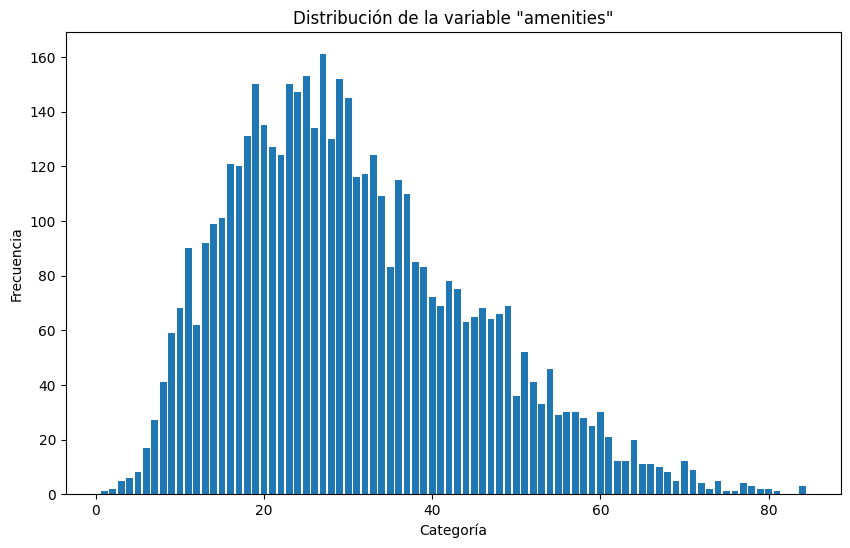

In [ ]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(data['amenities'].value_counts().index, data['amenities'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "amenities"')

# Muestra el gráfico
plt.show()

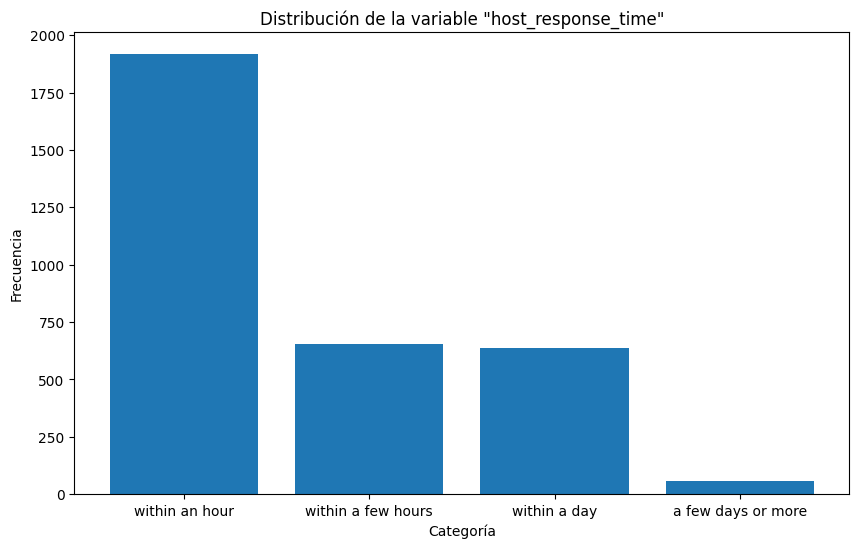

In [8]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(data['host_response_time'].value_counts().index, data['host_response_time'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "host_response_time"')

# Muestra el gráfico
plt.show()

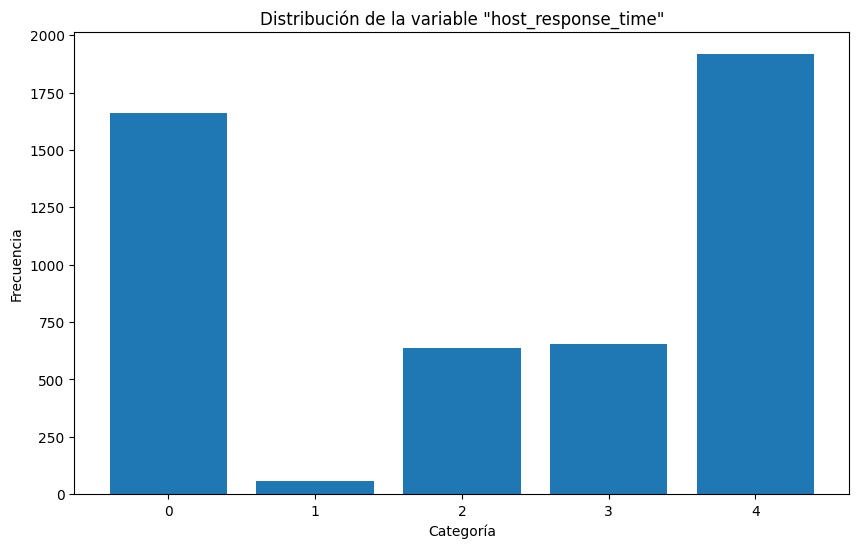

In [53]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(data['host_response_time'].value_counts().index, data['host_response_time'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "host_response_time"')

# Muestra el gráfico
plt.show()

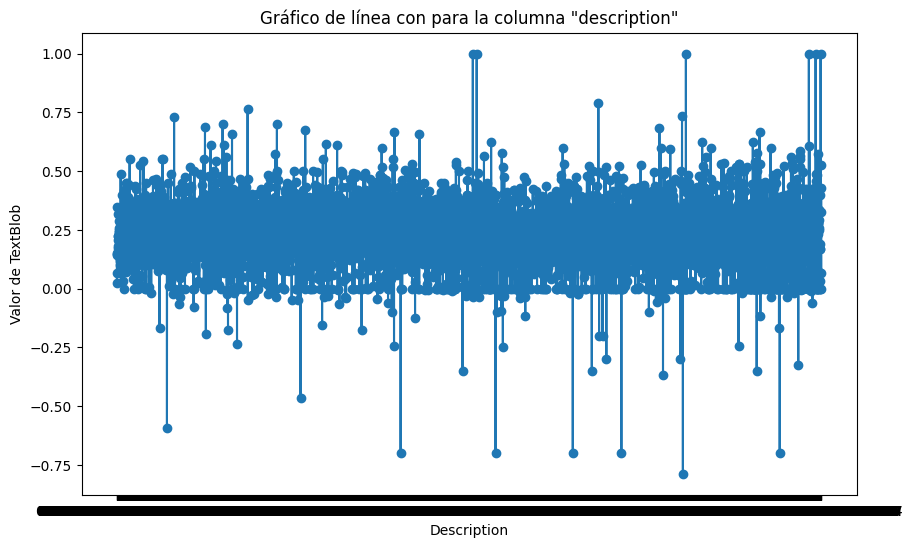

In [ ]:
# Convertir categorías en valores numéricos
valores_numericos = np.arange(len(data['description']))

# Crear gráfico de línea
plt.figure(figsize=(10, 6))
plt.plot(valores_numericos, data['description'], marker='o')

# Configurar ejes
plt.xticks(valores_numericos, data['description'])
plt.xlabel('Description')
plt.ylabel('Valor de TextBlob')
plt.title('Gráfico de línea con para la columna "description"')

# Mostrar el gráfico
plt.show()

In [ ]:
!pip install folium
import folium
from folium import plugins
mapa = folium.Map(location=[52, 4], zoom_start=10)
# Agregar marcadores al mapa
for index, row in data.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(mapa)
mapa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Crear el mapa
latitud_centro = 52  # Latitud del centro del mapa
longitud_centro = 4  # Longitud del centro del mapa
mapa = folium.Map(location=[latitud_centro, longitud_centro], zoom_start=10)

# Definir el diccionario de colores para cada grupo
colores = {
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'orange',
    5: 'purple',
    6: 'yellow',
    7: 'pink',
    8: 'brown',
    9: 'gray',
    10: 'cyan'
}

# Agregar marcadores al mapa con color según el grupo en la tercera columna
for index, row in data.iterrows():
    grupo = row['coordinates']
    if grupo in colores:
        color = colores[grupo]
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color=color,
            fill=True,
            fill_color=color
        ).add_to(mapa)

# Mostrar el mapa
mapa

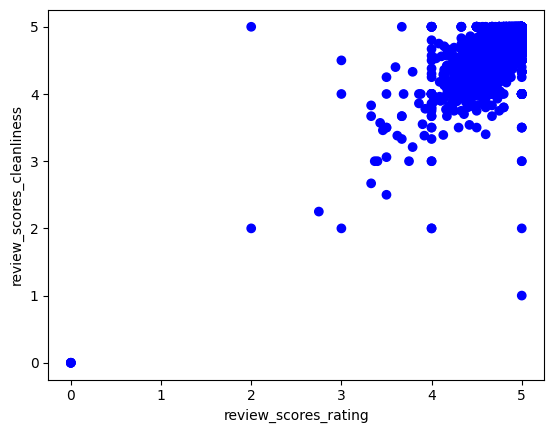

In [ ]:
# Filtrar los valores faltantes en la columna "z"
filtered_df = data.dropna(subset=['host_neighbourhood'])

# Extraer los valores de las columnas "rating_1" y "rating_2" en dos arreglos separados
x = filtered_df['review_scores_rating'].values
y = filtered_df['review_scores_cleanliness'].values

# Crear un arreglo booleano para identificar los valores faltantes
is_missing = data['host_neighbourhood'].isnull().values

# Crear el gráfico de dispersión con colores distintos para los datos faltantes
plt.scatter(data['review_scores_rating'], data['review_scores_cleanliness'], c=np.where(is_missing, 'red', 'blue'))
plt.xlabel('review_scores_rating')
plt.ylabel('review_scores_cleanliness')
plt.show()


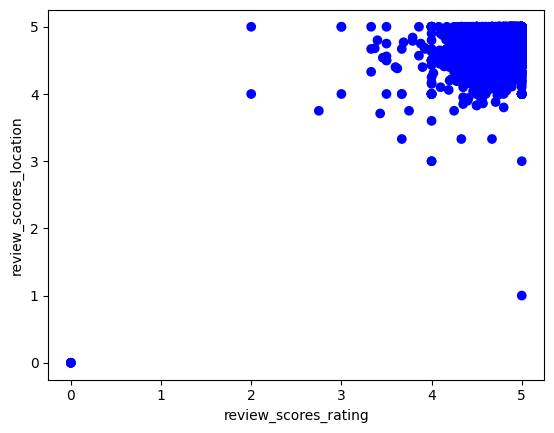

In [ ]:
# Filtrar los valores faltantes en la columna "z"
filtered_df = data.dropna(subset=['host_response_rate'])

# Extraer los valores de las columnas "rating_1" y "rating_2" en dos arreglos separados
x = filtered_df['review_scores_rating'].values
y = filtered_df['review_scores_location'].values

# Crear un arreglo booleano para identificar los valores faltantes
is_missing = data['host_response_rate'].isnull().values

# Crear el gráfico de dispersión con colores distintos para los datos faltantes
plt.scatter(data['review_scores_rating'], data['review_scores_location'], c=np.where(is_missing, 'green', 'blue'))
plt.xlabel('review_scores_rating')
plt.ylabel('review_scores_location')
plt.show()

### Variables numéricas

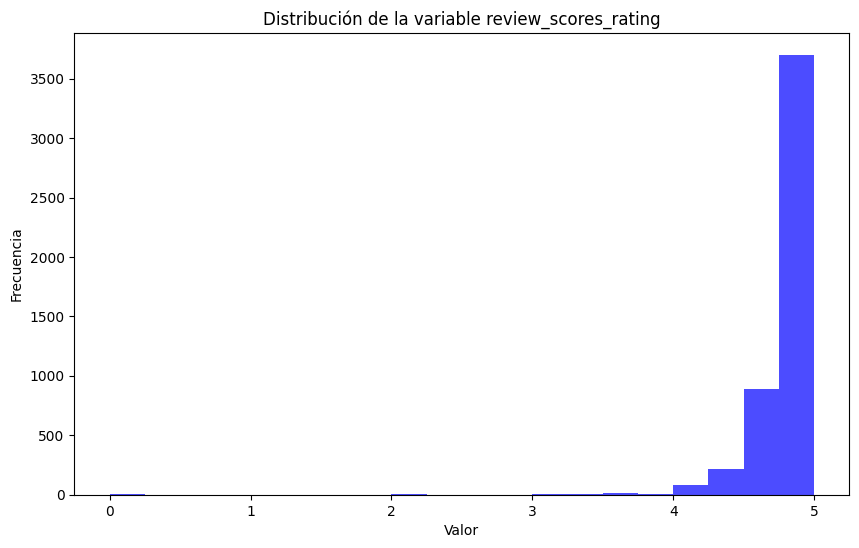

In [ ]:
#Gráfico de distribución
plt.figure(figsize=(10, 6))
plt.hist(data['review_scores_rating'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable review_scores_rating')
plt.show()

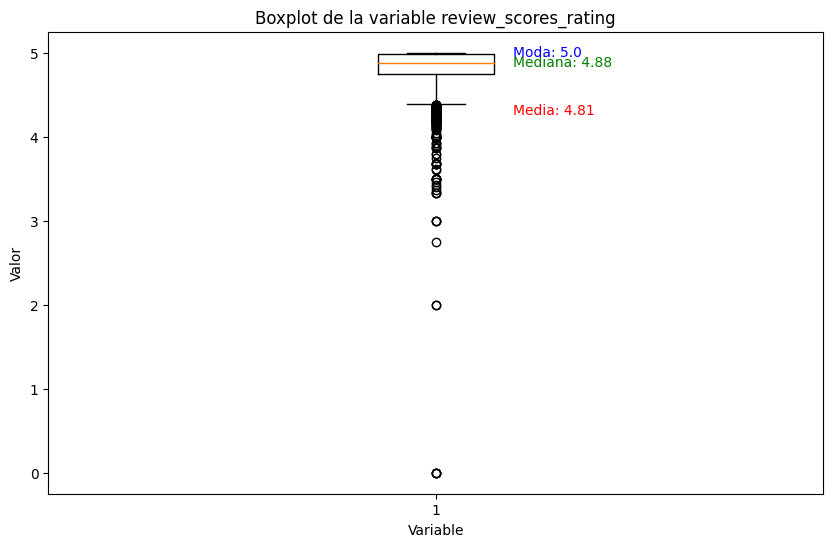

In [ ]:
#Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data['review_scores_rating'])
plt.xlabel('Variable')
plt.ylabel('Valor')
plt.title('Boxplot de la variable review_scores_rating')
moda = data['review_scores_rating'].mode().values[0]
media = data['review_scores_rating'].mean()
mediana = data['review_scores_rating'].median()
plt.text(1.1, media-0.5, f'Media: {media:.2f}', ha='left', va='center', color='red')
plt.text(1.1, mediana, f'Mediana: {mediana:.2f}', ha='left', va='center', color='green')
plt.text(1.1, moda, f'Moda: {moda}', ha='left', va='center', color='blue')
plt.show()

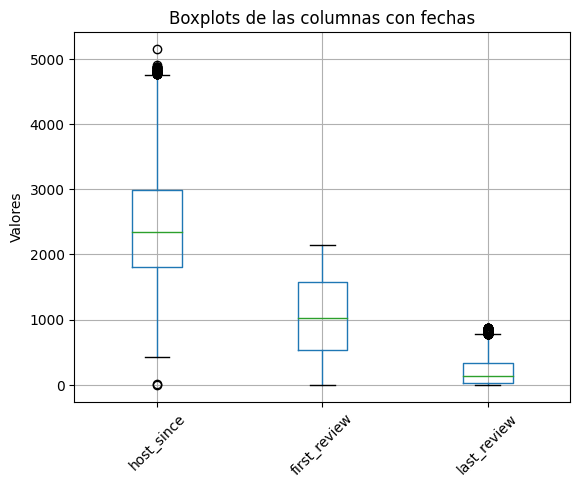

In [ ]:
# Especificar las columnas para los boxplots
columnas = ['host_since', 'first_review', 'last_review']  


data[columnas].boxplot()
plt.title('Boxplots de las columnas con fechas')
plt.ylabel('Valores')
plt.xticks(rotation=45)  
plt.show()

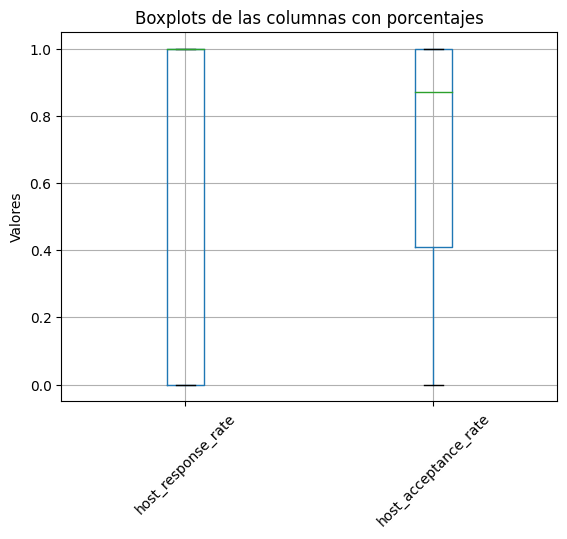

In [ ]:
# Especificar las columnas para los boxplots
columnas = ['host_response_rate', 'host_acceptance_rate']  


data[columnas].boxplot()
plt.title('Boxplots de las columnas con porcentajes')
plt.ylabel('Valores')
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para una mejor visualización
plt.show()

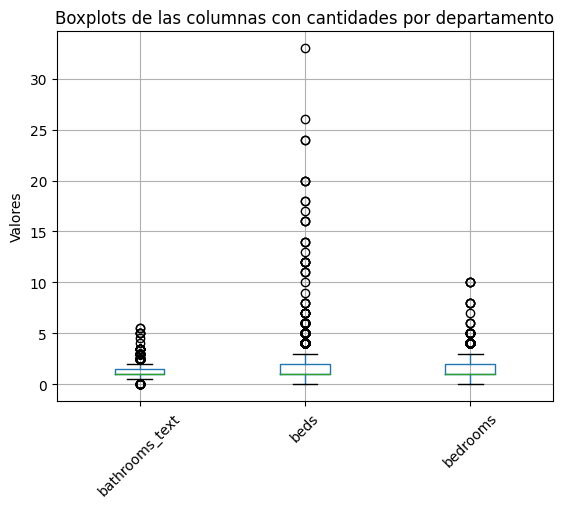

In [ ]:
# Especificar las columnas para los boxplots
columnas = ['bathrooms_text', 'beds', 'bedrooms']  


data[columnas].boxplot()
plt.title('Boxplots de las columnas con cantidades por departamento')
plt.ylabel('Valores')
plt.xticks(rotation=45) 
plt.show()

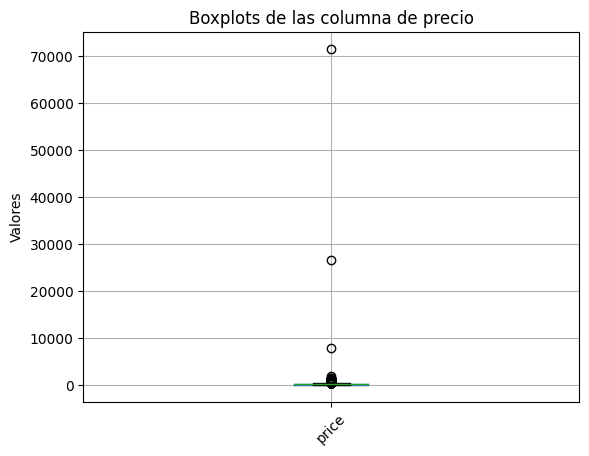

In [ ]:
# Especificar las columnas para los boxplots
columnas = ['price']  


data[columnas].boxplot()
plt.title('Boxplots de las columna de precio')
plt.ylabel('Valores')
plt.xticks(rotation=45) 
plt.show()

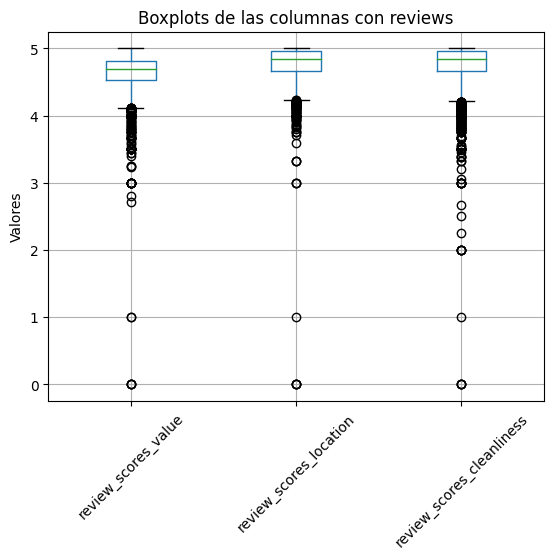

In [ ]:
# Especificar las columnas para los boxplots
columnas = ['review_scores_value', 'review_scores_location', 'review_scores_cleanliness']  


data[columnas].boxplot()
plt.title('Boxplots de las columnas con reviews')
plt.ylabel('Valores')
plt.xticks(rotation=45) 
plt.show()

<Axes: >

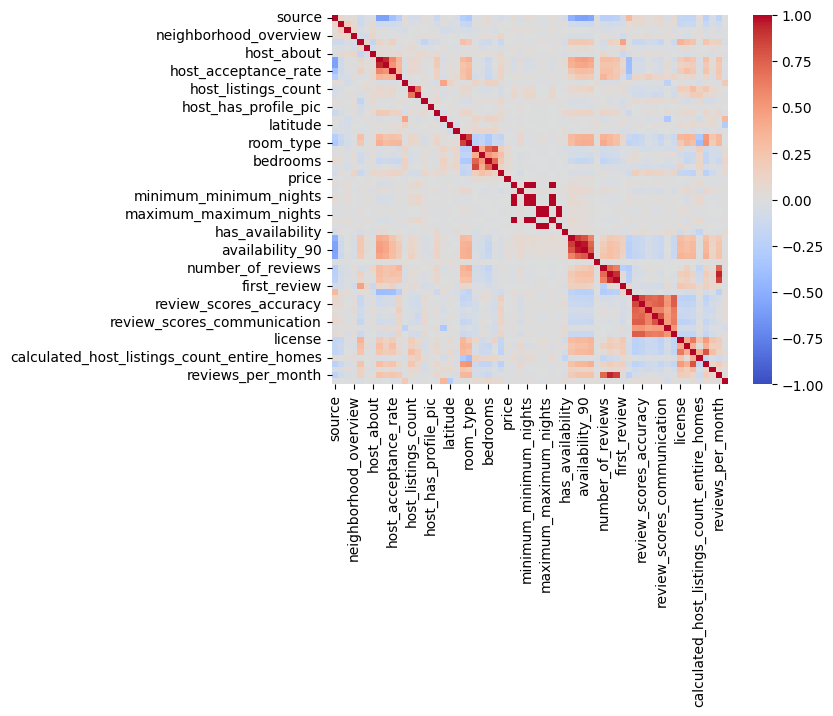

In [ ]:
# Calcular la matriz de correlación
matriz_correlacion = data.corr()
sns.heatmap(matriz_correlacion, annot=False, cmap="coolwarm", cbar=True, vmin=-1, vmax=1)

## EDA (test)

### Variables Categóricas

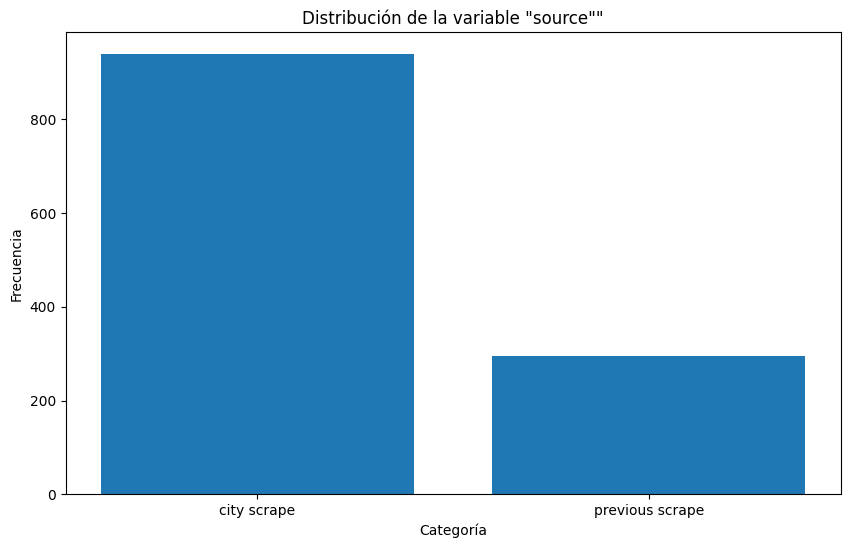

In [59]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(test['source'].value_counts().index, test['source'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "source""')

# Muestra el gráfico
plt.show()

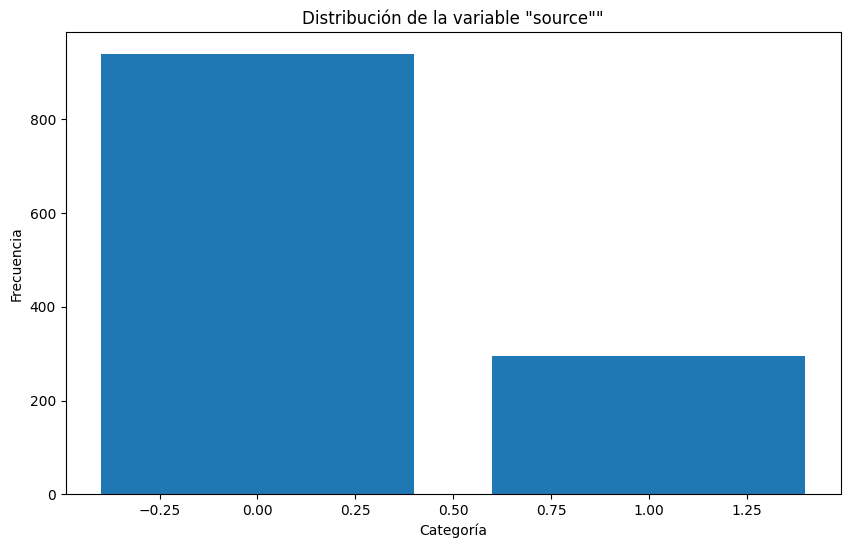

In [110]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(test['source'].value_counts().index, test['source'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "source""')

# Muestra el gráfico
plt.show()

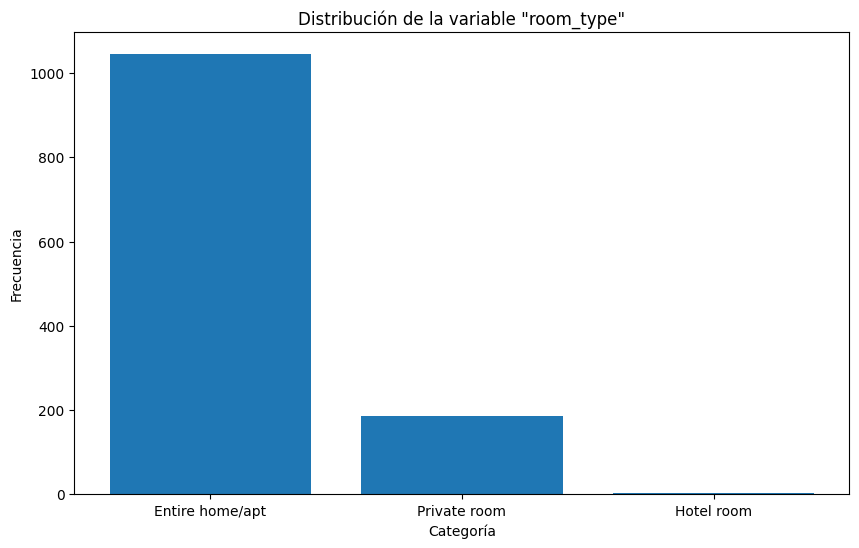

In [60]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(test['room_type'].value_counts().index, test['room_type'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "room_type"')

# Muestra el gráfico
plt.show()

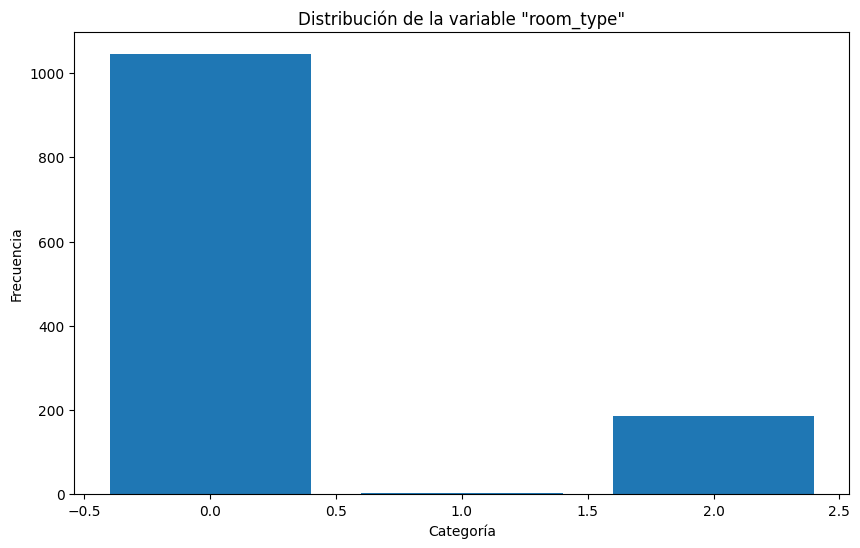

In [111]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(test['room_type'].value_counts().index, test['room_type'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "room_type"')

# Muestra el gráfico
plt.show()

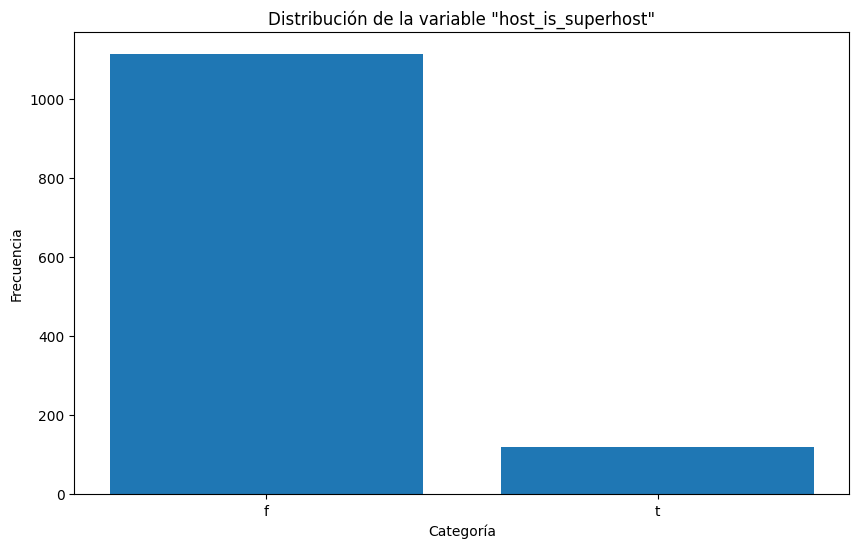

In [61]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(test['host_is_superhost'].value_counts().index, test['host_is_superhost'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "host_is_superhost"')

# Muestra el gráfico
plt.show()

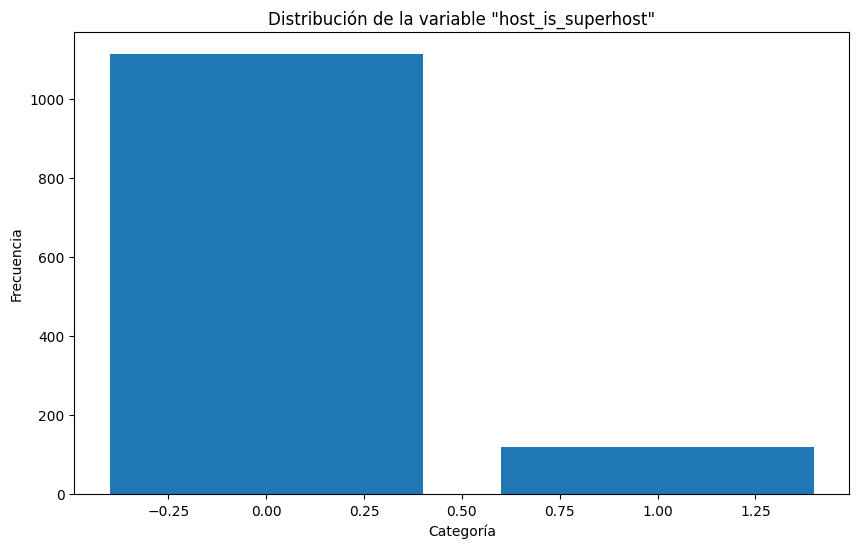

In [112]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(test['host_is_superhost'].value_counts().index, test['host_is_superhost'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "host_is_superhost"')

# Muestra el gráfico
plt.show()

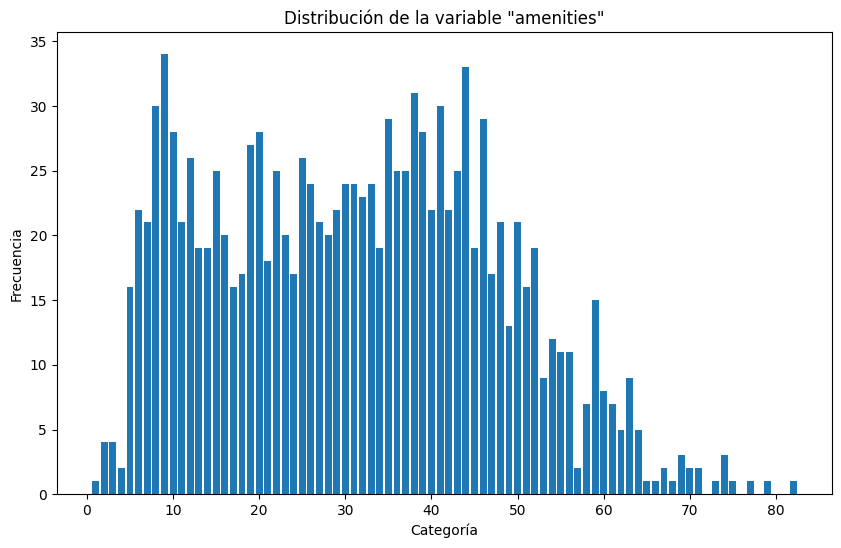

In [113]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(test['amenities'].value_counts().index, test['amenities'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "amenities"')

# Muestra el gráfico
plt.show()

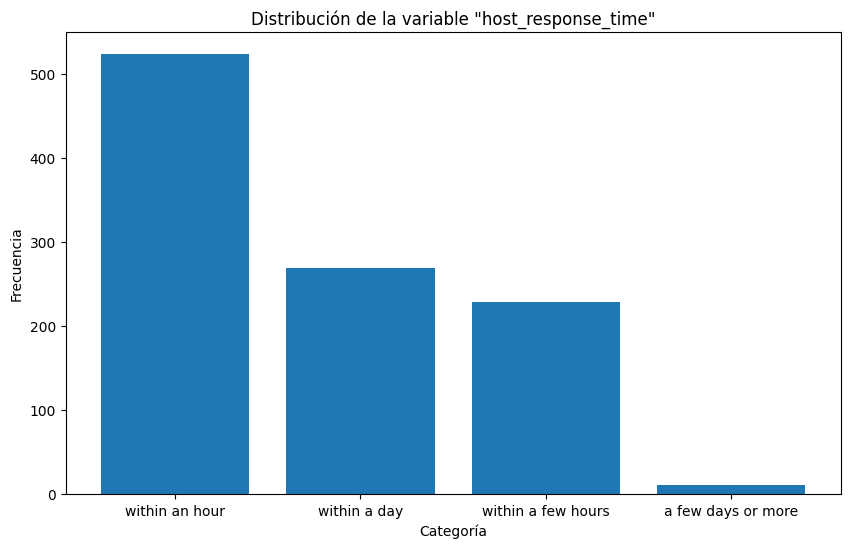

In [62]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(test['host_response_time'].value_counts().index, test['host_response_time'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "host_response_time"')

# Muestra el gráfico
plt.show()

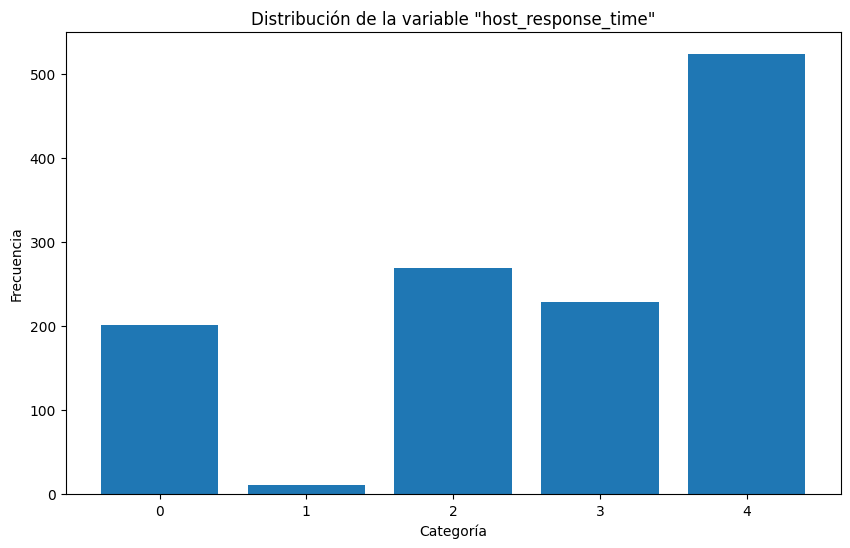

In [114]:
#Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(test['host_response_time'].value_counts().index, test['host_response_time'].value_counts())

# Agrega etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable "host_response_time"')

# Muestra el gráfico
plt.show()

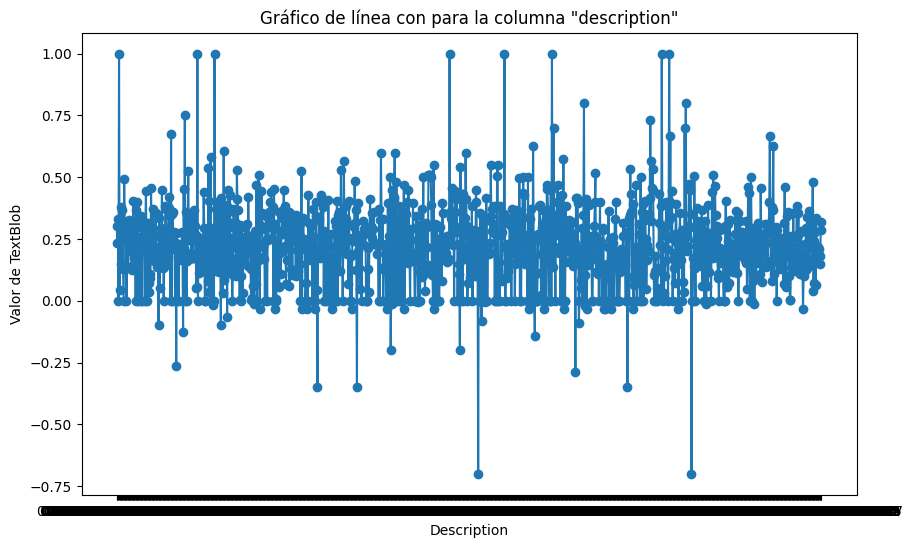

In [115]:
# Convertir categorías en valores numéricos
valores_numericos = np.arange(len(test['description']))

# Crear gráfico de línea
plt.figure(figsize=(10, 6))
plt.plot(valores_numericos, test['description'], marker='o')

# Configurar ejes
plt.xticks(valores_numericos, test['description'])
plt.xlabel('Description')
plt.ylabel('Valor de TextBlob')
plt.title('Gráfico de línea con para la columna "description"')

# Mostrar el gráfico
plt.show()

In [116]:
!pip install folium
import folium
from folium import plugins
mapa = folium.Map(location=[52, 4], zoom_start=10)
# Agregar marcadores al mapa
for index, row in test.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(mapa)
mapa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
# Crear el mapa
latitud_centro = 52  # Latitud del centro del mapa
longitud_centro = 4  # Longitud del centro del mapa
mapa = folium.Map(location=[latitud_centro, longitud_centro], zoom_start=10)

# Definir el diccionario de colores para cada grupo
colores = {
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'orange',
    5: 'purple',
    6: 'yellow',
    7: 'pink',
    8: 'brown',
    9: 'gray',
    10: 'cyan'
}

# Agregar marcadores al mapa con color según el grupo en la tercera columna
for index, row in test.iterrows():
    grupo = row['coordinates']
    if grupo in colores:
        color = colores[grupo]
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color=color,
            fill=True,
            fill_color=color
        ).add_to(mapa)

# Mostrar el mapa
mapa

### Variables Numéricas

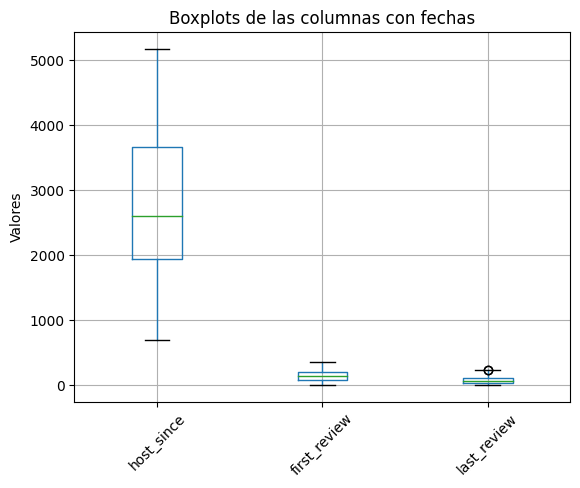

In [120]:
# Especificar las columnas para los boxplots
columnas = ['host_since', 'first_review', 'last_review']  


test[columnas].boxplot()
plt.title('Boxplots de las columnas con fechas')
plt.ylabel('Valores')
plt.xticks(rotation=45)  
plt.show()

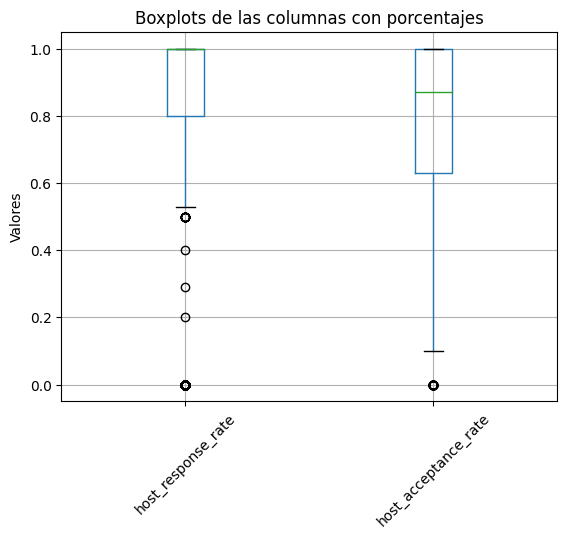

In [121]:
# Especificar las columnas para los boxplots
columnas = ['host_response_rate', 'host_acceptance_rate']  


test[columnas].boxplot()
plt.title('Boxplots de las columnas con porcentajes')
plt.ylabel('Valores')
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para una mejor visualización
plt.show()

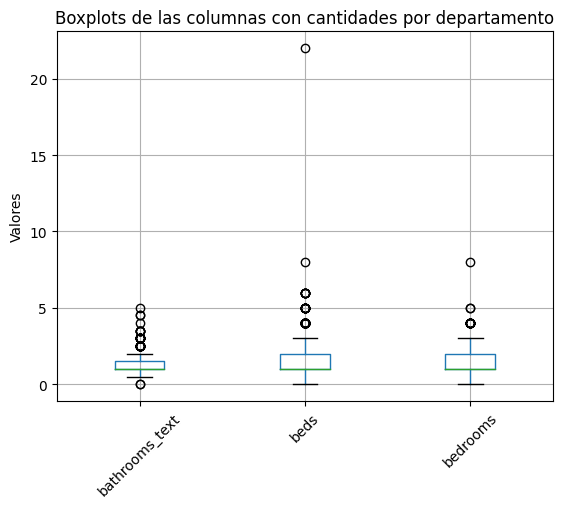

In [122]:
# Especificar las columnas para los boxplots
columnas = ['bathrooms_text', 'beds', 'bedrooms']  


test[columnas].boxplot()
plt.title('Boxplots de las columnas con cantidades por departamento')
plt.ylabel('Valores')
plt.xticks(rotation=45) 
plt.show()

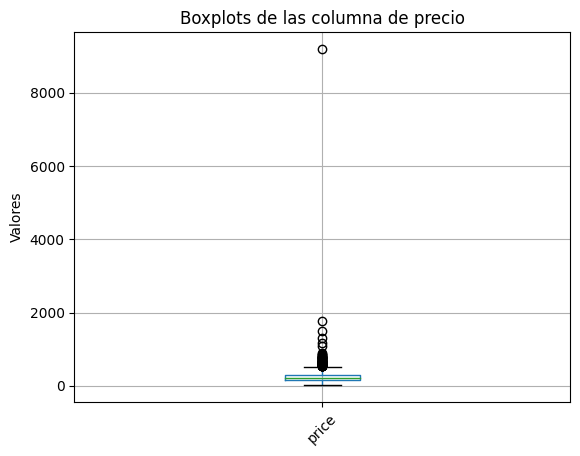

In [123]:
# Especificar las columnas para los boxplots
columnas = ['price']  


test[columnas].boxplot()
plt.title('Boxplots de las columna de precio')
plt.ylabel('Valores')
plt.xticks(rotation=45) 
plt.show()

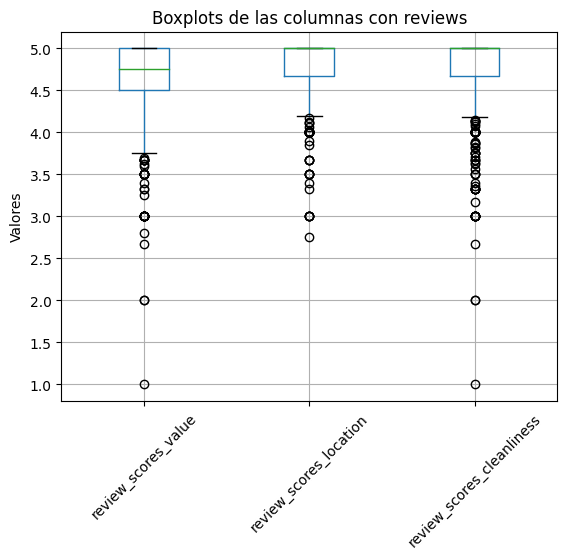

In [124]:
# Especificar las columnas para los boxplots
columnas = ['review_scores_value', 'review_scores_location', 'review_scores_cleanliness']  


test[columnas].boxplot()
plt.title('Boxplots de las columnas con reviews')
plt.ylabel('Valores')
plt.xticks(rotation=45) 
plt.show()

<Axes: >

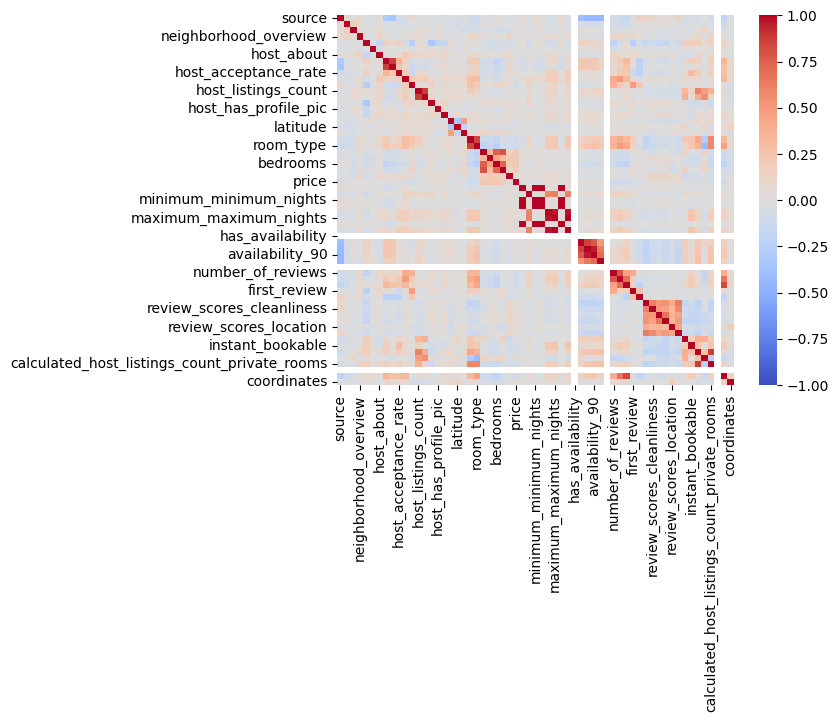

In [125]:
# Calcular la matriz de correlación
matriz_correlacion = test.corr()
sns.heatmap(matriz_correlacion, annot=False, cmap="coolwarm", cbar=True, vmin=-1, vmax=1)

## Modelo Ganador: XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

# Dividir los datos en conjuntos de entrenamiento y prueba
X = data.drop("review_scores_rating", axis=1)  # Características (68 columnas)
y = data["review_scores_rating"]  # Columna objetivo a predecir

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los hiperparámetros y los valores a explorar
parametros = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 5]
}

# Inicializar el clasificador XGBoost
modelo = xgb.XGBRegressor()

# Realizar Grid Search
grid_search = GridSearchCV(estimator=modelo, param_grid=parametros, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo con los mejores hiperparámetros
modelo_final = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = modelo_final.predict(X_test)

# Calcular el coeficiente R cuadrado (R2)
r2 = r2_score(y_test, y_pred)

print("Coeficiente R cuadrado (R2):", r2)

Coeficiente R cuadrado (R2): 0.792089639162785

Mejores hiperparámetros:


1. max_depth = 3 
2. learning_rate = 0.01
3. n_estimators = 1000
4. subsample = 0.8
5. min_child_weight = 5

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

# Entrenar el modelo XGBoost
X_train, X_test, y_train, y_test = train_test_split(data.drop('review_scores_rating', axis=1), data['review_scores_rating'], test_size=0.2, random_state=42)
model = xgb.XGBRegressor(max_depth = 3, learning_rate = 0.01, n_estimators = 1000, subsample = 0.8, min_child_weight = 5)
model.fit(X_train, y_train)

# Obtener la importancia de las características
importancia_caracteristicas = model.feature_importances_

columnas_data = np.array([col for col in data.columns if col != 'review_scores_rating'])

# Crear el DataFrame combinando los arrays
feature_importance = pd.DataFrame({'Column': columnas_data, 'Feature importance': importancia_caracteristicas})
feature_importance = feature_importance.sort_values('Feature importance', ascending=False)
print(feature_importance)

                                          Column  Feature importance
47                        review_scores_accuracy            0.170907
50                   review_scores_communication            0.061930
49                         review_scores_checkin            0.050951
59                             reviews_per_month            0.044187
31                        maximum_minimum_nights            0.043297
43                         number_of_reviews_ltm            0.039881
48                     review_scores_cleanliness            0.039608
52                           review_scores_value            0.034556
9                           host_acceptance_rate            0.033197
39                               availability_90            0.031474
60                                   coordinates            0.025635
6                                     host_about            0.024421
28                                minimum_nights            0.022990
10                             hos